# Evolution Algorithm

In [0]:
# setup Google Colaboratory
!mkdir models
!mkdir data
!mkdir data/stock_prices
!mkdir evolution_model_graphs

## Import dependencies

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
from os import path

In [0]:
from build_dataset import build_dataset

In [4]:
from models.dnn_regression import DenseNeuralNetwork

Using TensorFlow backend.


In [0]:
import json
from keras.callbacks import TensorBoard
from keras.utils import plot_model
from hashlib import sha256

## Get last run data

In [0]:
last_run = None
if path.isfile("last_run.json"):
    with open("last_run.json", "r") as last_run_file:
        last_run = json.load(last_run_file)

## Initialize models

In [0]:
population = []

In [0]:
POPULATION_SIZE = 10

In [9]:
input_options = {
    "config": [
        {"type": "lookback", "n": 22, "stock_code": "GOOGL", "column": "adjusted_close"},
        {"type": "moving_avg", "n": 5, "stock_code": "GOOGL", "column": "adjusted_close"},
        {"type": "moving_avg", "n": 10, "stock_code": "GOOGL", "column": "adjusted_close"},
        {"type": "moving_avg", "n": 30, "stock_code": "GOOGL", "column": "adjusted_close"},
        {"type": "moving_avg", "n": 90, "stock_code": "GOOGL", "column": "adjusted_close"},
        {"type": "moving_avg", "n": 180, "stock_code": "GOOGL", "column": "adjusted_close"},
        {"type": "moving_avg", "n": 365, "stock_code": "GOOGL", "column": "adjusted_close"}
    ],
    "stock_codes": ["GOOGL"],
    "stock_code": "GOOGL",
    "column": "adjusted_close"
}
print(sha256(json.dumps(input_options).encode()).hexdigest())

6797101d4426f264d5fe3ee949b4b105e6427b7109e8061f24e89512172761f7


In [0]:
stock_code = "GOOGL"

In [0]:
if last_run is not None:
    population = [DenseNeuralNetwork(
        model["model_options"],
        model["input_options"],
        model["stock_code"]
    ) for model in last_run["population"]]
else:
    init_model_options = DenseNeuralNetwork.random_model_options(POPULATION_SIZE, "dense")
    for i in range(POPULATION_SIZE):
        population.append(DenseNeuralNetwork(
            init_model_options[i],
            input_options,
            stock_code
        ))

## Initialize errors

In [0]:
errors = []
error_history = []

In [0]:
if last_run is not None:
    errors = last_run["errors"]
    error_history = last_run["error_history"]
else:
    for model_idx, model in enumerate(population):
        print("Initial model {}".format(model_idx + 1))
        
        # prepare the data
        x, y = build_dataset(model.input_options, model.model_options["predict_n"], True)
        # split the data into training set and testing set
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
        # train the model
        model.train(
            x_train,
            y_train,
            verbose=0,
            callbacks=[TensorBoard(log_dir="./evolution_tensorboard_logs/initial_{}".format(model_idx + 1))]
        )
        # calculate the model error
        error = model.model.evaluate(x_test, y_test, verbose=0)
        errors.append(error[-1])
    error_history = [errors]

errors = np.array(errors)
error_history = np.array(error_history)

## Evolution algorithm

In [0]:
last_iterations = last_run["last_iterations"] if last_run is not None else 0

In [0]:
ITERATIONS = 10

In [0]:
for i in range(last_iterations, last_iterations + ITERATIONS):
    print("Iteration {}".format(i + 1))
    
    # randomly choose 2 models
    model_idxs = np.random.choice(np.arange(POPULATION_SIZE), size=2, replace=False)
    
    better_model_idx = -1
    worse_model_idx = -1
    if errors[model_idxs[0]] <= errors[model_idxs[1]]:
        better_model_idx = model_idxs[0]
        worse_model_idx = model_idxs[1]
    else:
        better_model_idx = model_idxs[1]
        worse_model_idx = model_idxs[0]
    
    parent_model = population[better_model_idx]
    
    # kill and remove the worse model
    population.pop(worse_model_idx)
    errors = np.delete(errors, worse_model_idx)
    
    # reproduce the child model
    child_model_options, mutation = DenseNeuralNetwork.evolve_model_options(parent_model.model_options)
    print("Mutation: {}".format(mutation))
    child_model = DenseNeuralNetwork(
        child_model_options,
        input_options,
        stock_code
    )
    
    # train the child model
    # prepare the data
    x, y = build_dataset(child_model.input_options, child_model.model_options["predict_n"], True)
    # split the data into training set and testing set
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
    # train the child model
    child_model.train(
        x_train,
        y_train,
        verbose=0,
        callbacks=[TensorBoard(log_dir="./evolution_tensorboard_logs/{}".format(i + 1))]
    )
    # calculate the child model error
    child_error = child_model.model.evaluate(x_test, y_test, verbose=0)
    
    # append the child model and its error
    population.append(child_model)
    errors = np.append(errors, child_error[-1])
    error_history = np.append(error_history, [errors], axis=0)
    
    # plot the child model graph
    plot_model(child_model.model, to_file="evolution_model_graphs/{}.png".format(i + 1))

Iteration 1
Mutation: remove_dense_layer
Iteration 2
Mutation: batch_size
Iteration 3
Mutation: change_activation
Iteration 4
Mutation: change_units
Iteration 5
Mutation: remove_dense_layer
Iteration 6
Mutation: batch_size
Iteration 7
Mutation: change_activation
Iteration 8
Mutation: learning_rate
Iteration 9
Mutation: batch_size
Iteration 10
Mutation: change_units


In [0]:
# get the best model
best_model_idx = np.argmin(errors)
best_model = population[best_model_idx]

## Write this run data

In [0]:
with open("last_run.json", "w") as last_run_file:
    json.dump({
        "last_iterations": last_iterations + ITERATIONS,
        "population": [{
            "model_options": model.model_options,
            "input_options": model.input_options,
            "stock_code": model.stock_code
        } for model in population],
        "errors": errors.tolist(),
        "error_history": error_history.tolist()
    }, last_run_file, indent=4)

In [0]:
!zip -r evolution_tensorboard_logs.zip evolution_tensorboard_logs

  adding: evolution_tensorboard_logs/ (stored 0%)
  adding: evolution_tensorboard_logs/6/ (stored 0%)
  adding: evolution_tensorboard_logs/6/events.out.tfevents.1548857199.b89525f1e109 (deflated 90%)
  adding: evolution_tensorboard_logs/initial_5/ (stored 0%)
  adding: evolution_tensorboard_logs/initial_5/events.out.tfevents.1548856993.b89525f1e109 (deflated 90%)
  adding: evolution_tensorboard_logs/initial_10/ (stored 0%)
  adding: evolution_tensorboard_logs/initial_10/events.out.tfevents.1548857030.b89525f1e109 (deflated 90%)
  adding: evolution_tensorboard_logs/initial_6/ (stored 0%)
  adding: evolution_tensorboard_logs/initial_6/events.out.tfevents.1548857001.b89525f1e109 (deflated 90%)
  adding: evolution_tensorboard_logs/5/ (stored 0%)
  adding: evolution_tensorboard_logs/5/events.out.tfevents.1548857173.b89525f1e109 (deflated 90%)
  adding: evolution_tensorboard_logs/7/ (stored 0%)
  adding: evolution_tensorboard_logs/7/events.out.tfevents.1548857225.b89525f1e109 (deflated 90%)


In [0]:
!zip -r evolution_model_graphs.zip evolution_model_graphs

  adding: evolution_model_graphs/ (stored 0%)
  adding: evolution_model_graphs/3.png (deflated 8%)
  adding: evolution_model_graphs/8.png (deflated 7%)
  adding: evolution_model_graphs/7.png (deflated 8%)
  adding: evolution_model_graphs/10.png (deflated 8%)
  adding: evolution_model_graphs/2.png (deflated 8%)
  adding: evolution_model_graphs/9.png (deflated 8%)
  adding: evolution_model_graphs/1.png (deflated 8%)
  adding: evolution_model_graphs/5.png (deflated 7%)
  adding: evolution_model_graphs/4.png (deflated 8%)
  adding: evolution_model_graphs/6.png (deflated 8%)


## Plot predictions

In [0]:
import pandas as pd

In [0]:
import matplotlib.pyplot as plt

In [0]:
stock_prices = pd.read_csv("./data/stock_prices/" + stock_code + ".csv", index_col=0)["adjusted_close"].values[::-1]
stock_prices = stock_prices[-90:]
x = build_dataset(best_model.input_options, best_model.model_options["predict_n"], False)
prediction = best_model.predict(x)
plt.plot(np.arange(len(stock_prices)), stock_prices)
plt.plot(np.arange(len(stock_prices), len(stock_prices) + len(prediction)), prediction)

## Plot evolution data

Text(0.5, 0, 'Iteration')

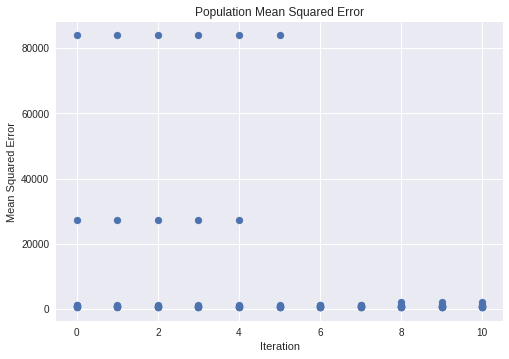

In [17]:
# plot evolution error history
plt.scatter(
    np.array([[i for _ in range(POPULATION_SIZE)] for i in range(error_history.shape[0])]).flatten(),
    error_history.flatten()
)
plt.title("Population Mean Squared Error")
plt.ylabel("Mean Squared Error")
plt.xlabel("Iteration")

Text(0.5, 0, 'Iteration')

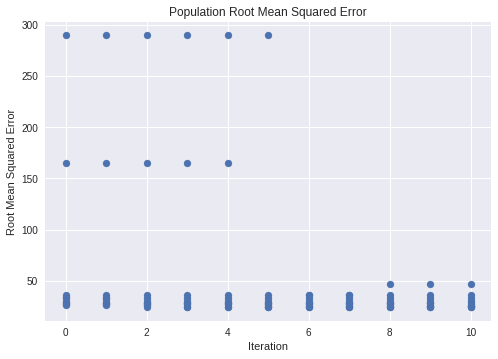

In [18]:
plt.scatter(
    np.array([[i for _ in range(POPULATION_SIZE)] for i in range(error_history.shape[0])]).flatten(),
    np.sqrt(error_history).flatten()
)
plt.title("Population Root Mean Squared Error")
plt.ylabel("Root Mean Squared Error")
plt.xlabel("Iteration")

Text(0.5, 0, 'Iteration')

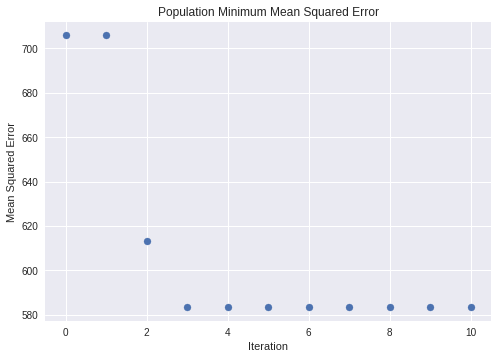

In [19]:
plt.scatter(
    np.arange(error_history.shape[0]),
    np.min(error_history, axis=1)
)
plt.title("Population Minimum Mean Squared Error")
plt.ylabel("Mean Squared Error")
plt.xlabel("Iteration")

Text(0.5, 0, 'Iteration')

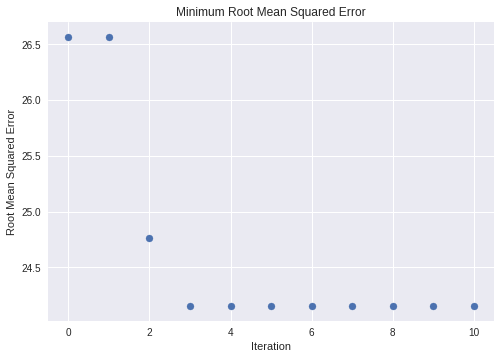

In [20]:
plt.scatter(
    np.arange(error_history.shape[0]),
    np.min(np.sqrt(error_history), axis=1)
)
plt.title("Minimum Root Mean Squared Error")
plt.ylabel("Root Mean Squared Error")
plt.xlabel("Iteration")